# An Assessment of the Current State of Real Estate

In [1]:
%pylab inline
from PIL import Image
import urllib.request as url
import io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels as sm
import statsmodels.formula.api as smf
import statsmodels.api as sma
import patsy
from statsmodels.graphics.api import abline_plot
import numpy.linalg as linalg
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets
from tabulate import tabulate
sns.set(context='notebook', style='whitegrid', palette='deep', font='sans-serif', font_scale=1, rc=None)

import datetime as dt
from fredapi import Fred
fred = Fred(api_key='30e6ecb242a73869e11cb35f6aa3afc3')

Populating the interactive namespace from numpy and matplotlib


## Commercial Real Estate as an Asset Class: 
1. Illiquid and leveraged.
2. Capital is global but risks are both global and **local**.
3. Out-sized returns.

## Commercial Real Estate as the Built Space:
1. CRE development is one of the riskiest plays.
2. Not necessarily lending but physics.  Local markets can move against you while property is being constructed and is leasing up.
3. Agglomeration economics is now more important for successful projects than macro.  (Don't fight the Fed.  Ignore it.)

## Commercial Real Estate as the New Tech:
1. Big data but not high frequency.
2. PropTech.
3. Data quality is paramount, and sophisticated algorithms cannot compensate for mismeasurement: "GIGO"
    * Office "asking rents" are imprecise measures of net effective rents.
    * Office vacancy rates are imprecise measures of space availability.
    * They are measured and produced at an insufficient geographical granularity.  Why should brokers determine what constitutes a real estate geography?

# The Current Economic Cycle

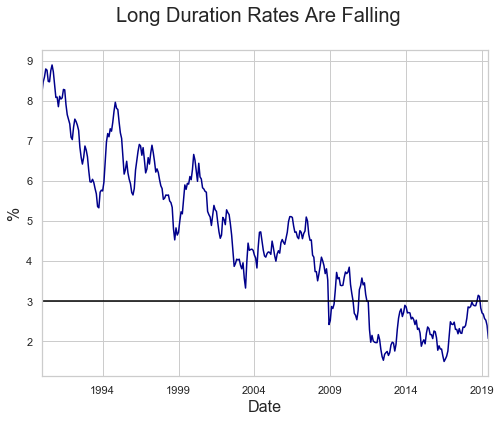

In [2]:
ten_year = fred.get_series("GS10", observation_start='1990-01-01')
one_year = fred.get_series("DGS1", observation_start='1990-01-01')
three_month = fred.get_series("DGS3MO", observation_start='1990-01-01')

ten_year.plot(color='darkblue', figsize=(8, 6))
plt.suptitle('Long Duration Rates Are Falling', fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.ylabel('%', fontsize=16)
plt.axhline(3.0, color="black")

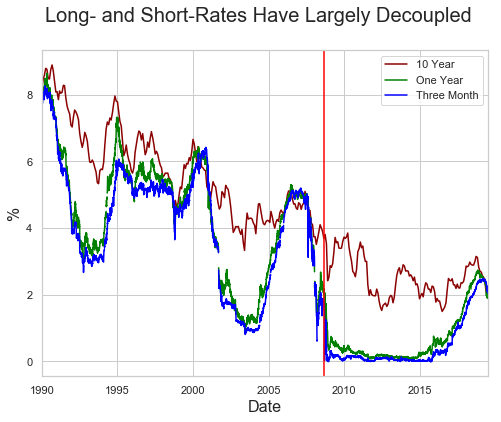

In [3]:
ten_year.plot(c='darkred', label='10 Year', figsize=(8, 6), )
one_year.plot(c='green', label='One Year')
three_month.plot(color='blue', label='Three Month')
plt.suptitle('Long- and Short-Rates Have Largely Decoupled', fontsize=20)
plt.legend()
plt.xlabel('Date', fontsize=16)
plt.ylabel('%', fontsize=16)
plt.axvline(dt.datetime(2008, 9, 15), color="red")

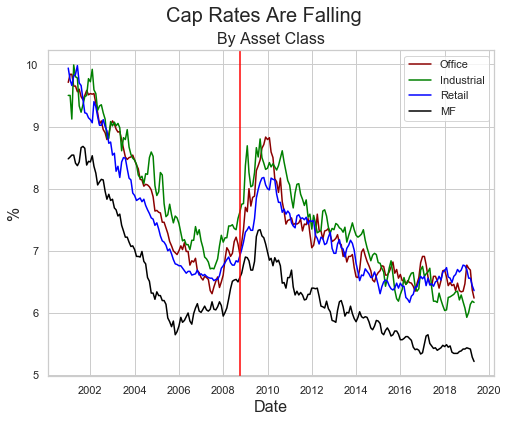

In [4]:
cap_rates = pd.read_excel("cap rates.xls", index_col='Date')
cap_rates = cap_rates.drop(['GT10'], axis=1)
cap_rates = cap_rates.rename(columns={"Retail":"R", "Multifam":"M", "Indust":"I", "Office":"O"})

plt.figure(figsize = (8, 6))
plt.suptitle("Cap Rates Are Falling", fontsize=20)
plt.title("By Asset Class", fontsize=16)
plt.plot(cap_rates['O'], label='Office', c='darkred')
plt.plot(cap_rates['I'], label='Industrial', c='green')
plt.plot(cap_rates['R'], label='Retail', c='blue')
plt.plot(cap_rates['M'], label='MF', c='black')
plt.legend()
plt.xlabel('Date', fontsize=16)
plt.ylabel('%', fontsize=16)
plt.axvline(dt.datetime(2008, 10, 1), color="red")

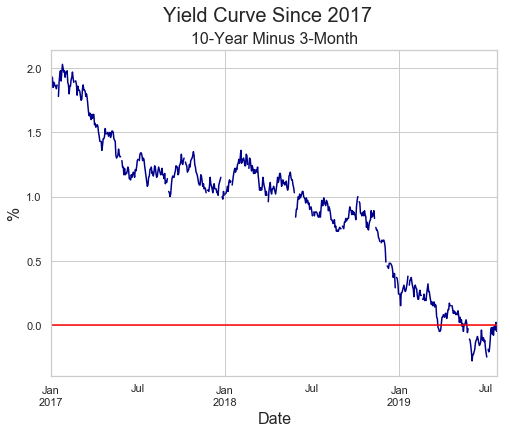

In [5]:
yield_curve = fred.get_series("T10Y3M", observation_start='2017-01-01')

yield_curve.plot(color='darkblue', figsize=(8, 6))
plt.suptitle('Yield Curve Since 2017', fontsize=20)
plt.title('10-Year Minus 3-Month', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.ylabel('%', fontsize=16)
plt.axhline(0, color="red")

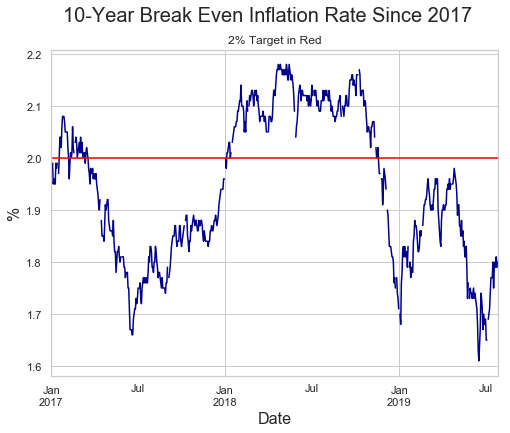

In [6]:
break_even = fred.get_series("T10YIE", observation_start='2017-01-01')

break_even.plot(color='darkblue', figsize=(8, 6))
plt.suptitle('10-Year Break Even Inflation Rate Since 2017', fontsize=20)
plt.title('2% Target in Red')
plt.xlabel('Date', fontsize=16)
plt.ylabel('%', fontsize=16)
plt.axhline(2, color="red")

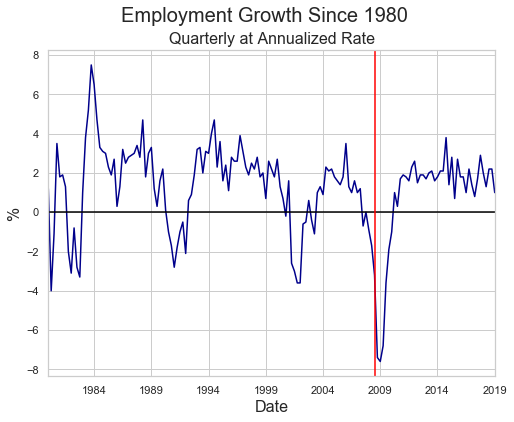

In [7]:
emp_growth = fred.get_series("PRS85006012", observation_start='1980-01-01')

emp_growth.plot(color='darkblue', figsize=(8, 6))
plt.suptitle('Employment Growth Since 1980', fontsize=20)
plt.title('Quarterly at Annualized Rate', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.ylabel('%', fontsize=16)
plt.axhline(0, color="black")
plt.axvline(dt.datetime(2008, 9, 15), color="red")

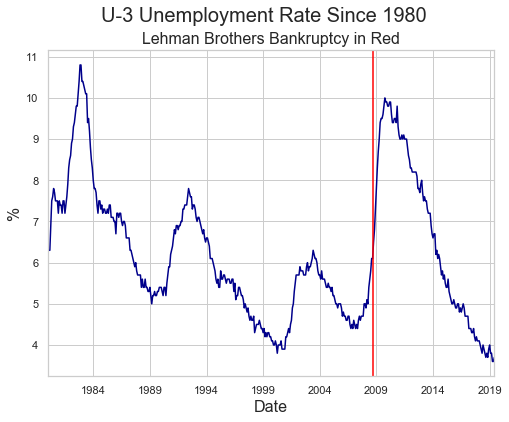

In [8]:
unemp_rate = fred.get_series("UNRATE", observation_start='1980-01-01')

unemp_rate.plot(color='darkblue', figsize=(8, 6))
plt.suptitle('U-3 Unemployment Rate Since 1980', fontsize=20)
plt.title('Lehman Brothers Bankruptcy in Red', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.ylabel('%', fontsize=16)
plt.axvline(dt.datetime(2008, 9, 15), color="red")

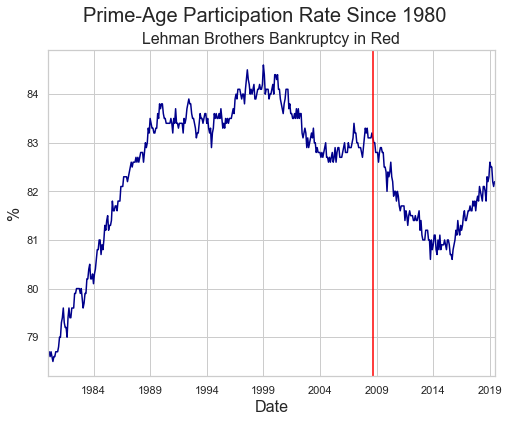

In [9]:
prime_part = fred.get_series("LNS11300060", observation_start='1980-01-01')

prime_part.plot(color='darkblue', figsize=(8, 6))
plt.suptitle('Prime-Age Participation Rate Since 1980', fontsize=20)
plt.title('Lehman Brothers Bankruptcy in Red', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.ylabel('%', fontsize=16)
plt.axvline(dt.datetime(2008, 9, 15), color="red")

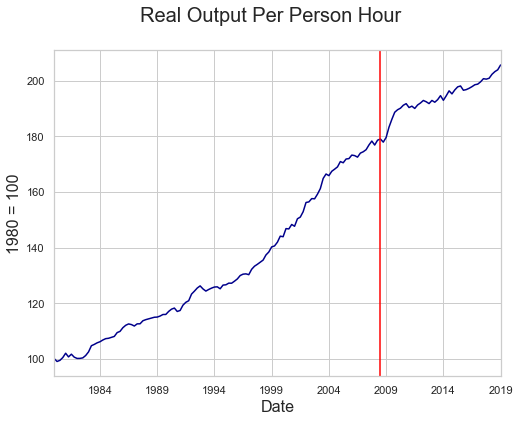

In [10]:
productivity = fred.get_series("OPHNFB", observation_start='1980-01-01') / 52 * 100

productivity.plot(color='darkblue', figsize=(8, 6))
plt.suptitle('Real Output Per Person Hour', fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.ylabel('1980 = 100', fontsize=16)
plt.axvline(dt.datetime(2008, 9, 15), color="red")

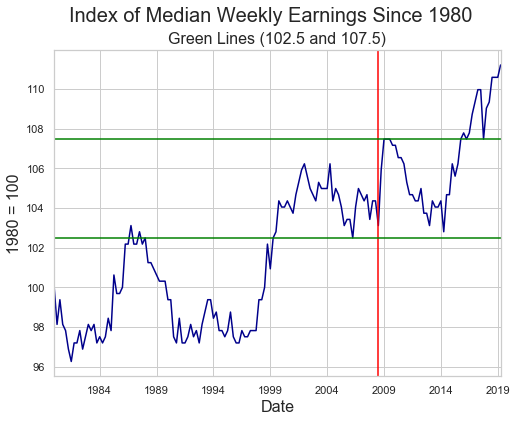

In [11]:
real_wage = fred.get_series("LES1252881600Q", observation_start='1980-01-01') / 321 * 100

real_wage.plot(color='darkblue', figsize=(8, 6))
plt.suptitle('Index of Median Weekly Earnings Since 1980', fontsize=20)
plt.title('Green Lines (102.5 and 107.5)', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.ylabel('1980 = 100', fontsize=16)
plt.axvline(dt.datetime(2008, 9, 15), color="red")
plt.axhline(107.5, color="green")
plt.axhline(102.5, color="green")

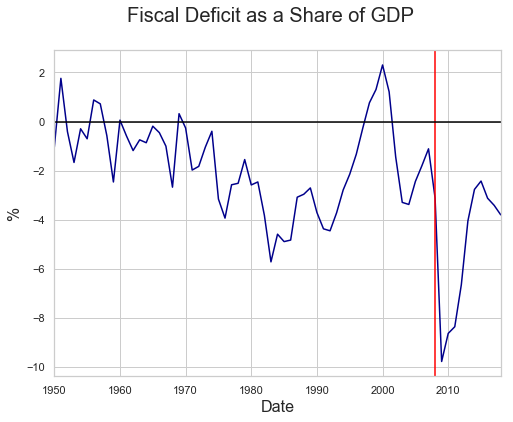

In [12]:
def_as_share = fred.get_series("FYFSGDA188S", observation_start='1950-01-01')

def_as_share.plot(color='darkblue', figsize=(8, 6))
plt.suptitle('Fiscal Deficit as a Share of GDP', fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.ylabel('%', fontsize=16)
plt.axvline(dt.datetime(2008, 9, 15), color="red")
plt.axhline(0.0, color="black")

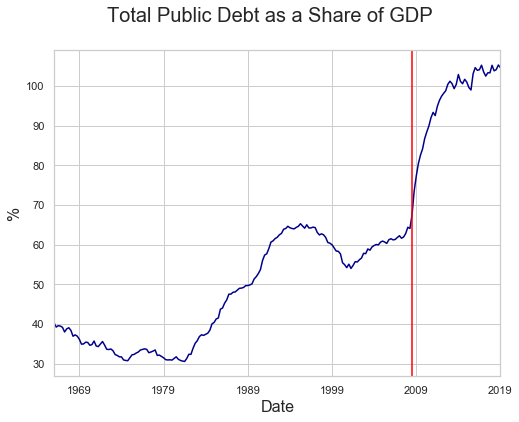

In [13]:
debt_as_share = fred.get_series("GFDEGDQ188S", observation_start='1950-01-01')

debt_as_share.plot(color='darkblue', figsize=(8, 6))
plt.suptitle('Total Public Debt as a Share of GDP', fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.ylabel('%', fontsize=16)
plt.axvline(dt.datetime(2008, 9, 15), color="red")

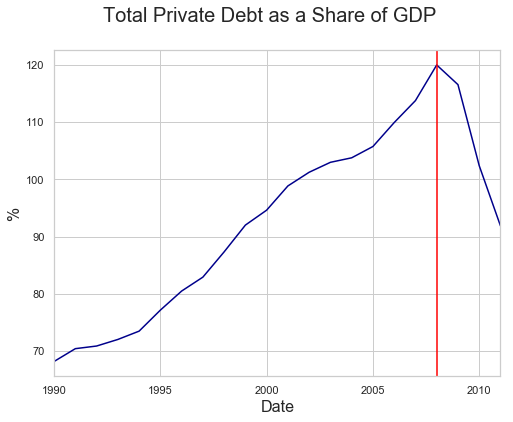

In [14]:
debt_as_share = fred.get_series("DDDM03USA156NWDB", observation_start='1950-01-01')

debt_as_share.plot(color='darkblue', figsize=(8, 6))
plt.suptitle('Total Private Debt as a Share of GDP', fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.ylabel('%', fontsize=16)
plt.axvline(dt.datetime(2008, 9, 15), color="red")

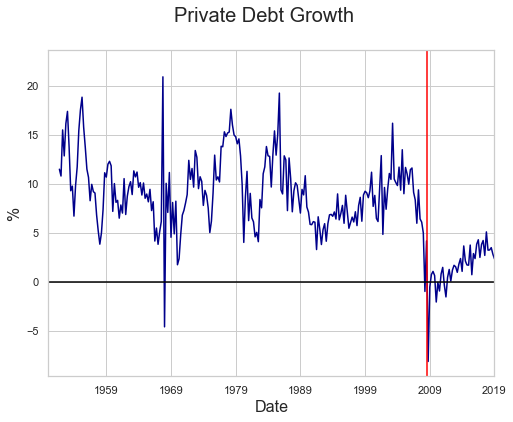

In [15]:
debt_as_share = fred.get_series("BOGZ1FG154104005Q", observation_start='1950-01-01')

debt_as_share.plot(color='darkblue', figsize=(8, 6))
plt.suptitle('Private Debt Growth', fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.ylabel('%', fontsize=16)
plt.axvline(dt.datetime(2008, 9, 15), color="red")
plt.axhline(0.0, color="black")

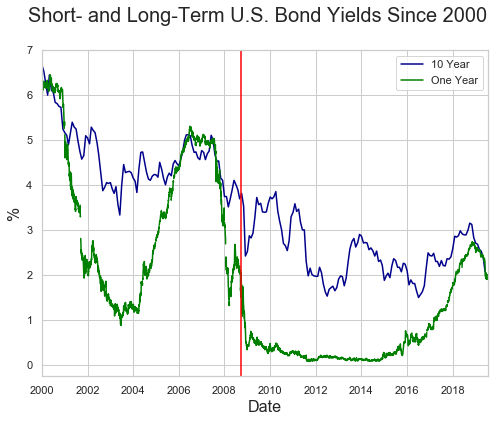

In [16]:
ten_year = fred.get_series("GS10", observation_start='2000-01-01')
one_year = fred.get_series("DGS1", observation_start='2000-01-01')

ten_year.plot(color='darkblue', figsize=(8, 6), label='10 Year')
one_year.plot(color='green', label='One Year')
plt.suptitle('Short- and Long-Term U.S. Bond Yields Since 2000', fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.ylabel('%', fontsize=16)
plt.legend()
plt.axvline(dt.datetime(2008, 9, 15), color="red")

# The Changing Landscape for Real Estate

1. Machine learning, prediction and big data
2. Co-working and e-commerce
3. The sharing economy and expanding the market for short-term stays
4. The re-emergence of agglomeration economics

# Data Science at Schack: Can We Predict These?

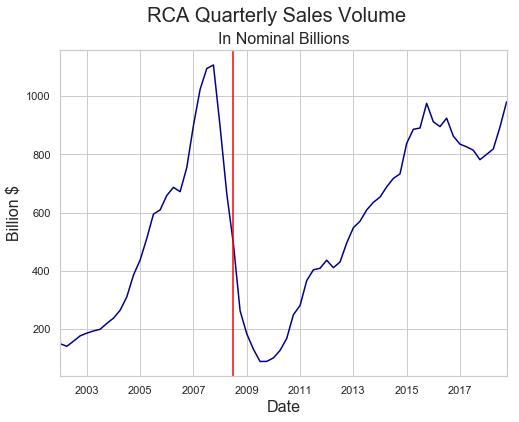

In [17]:
rca = pd.read_excel("RCA.xls", index_col='Date') / 400000000

rca["Volume"].plot(color='darkblue', figsize=(8, 6))
plt.suptitle('RCA Quarterly Sales Volume', fontsize=20)
plt.title('In Nominal Billions', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Billion $', fontsize=16)
plt.axvline(dt.datetime(2008, 9, 15), color="red")

In [18]:
caprates = pd.read_csv('nyc.csv', index_col='Time')

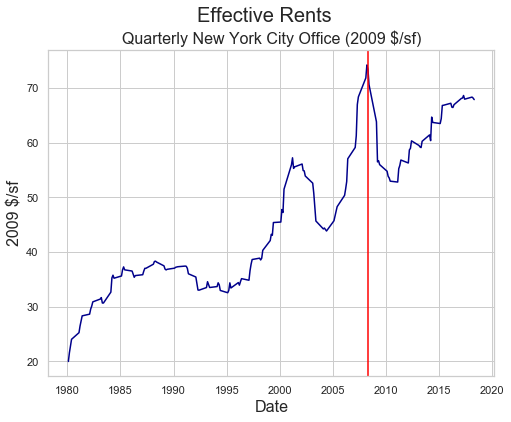

In [19]:
plt.figure(figsize = (8, 6))
plt.suptitle("Effective Rents", fontsize=20)
plt.title("Quarterly New York City Office (2009 $/sf)", fontsize=16)
plt.plot(caprates['TW Rent Index ($/sf)'], color='darkblue')
plt.xlabel('Date', fontsize=16)
plt.ylabel('2009 $/sf', fontsize=16)
plt.axvline(2008.3, color="red")

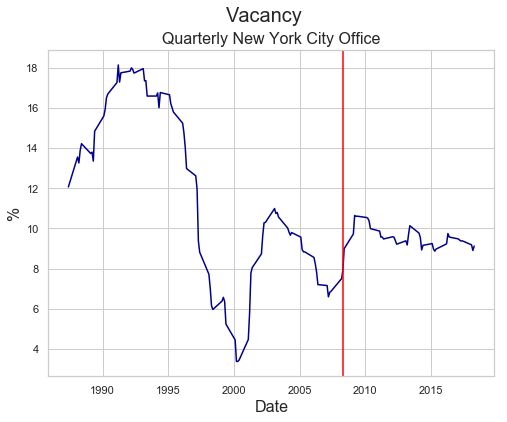

In [20]:
plt.figure(figsize = (8, 6))
plt.suptitle("Vacancy", fontsize=20)
plt.title("Quarterly New York City Office", fontsize=16)
plt.plot(caprates['Vacancy Rate (%)'], color='darkblue')
plt.xlabel('Date', fontsize=16)
plt.ylabel('%', fontsize=16)
plt.axvline(2008.3, color="red")